In [9]:
# Everything needed to run this notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.pipeline import Pipeline


## Introduction

In our previous notebook, which is named Exploratory Data Analysis (EDA), we got a better understanding of what the data looks like in the NBA-Player Stats-Season 24/25 dataset. We found that most of the data was numerical. We cleaned out the categorical data, plotted histograms to see the distribution of stats, and checked the correlation. In this notebook we are going to create a baseline model and do model tuning with more advanced models.

## Reading the CSV

We created a new dataset name **numeric_dataset.csv** which just contains numerical data. We are going to read this data set by using the **Pandas** library. We will get basic information about this dataset, including the shape and we will use the `.head()` so you know what data we are using to build the regression models. 

In [10]:
clean_data = pd.read_csv('/home/kylep/cs3120/project/NBA-EDA-and-Model-Tuning/data/numeric_dataset.csv')
print(f"The shape of the dataset is: ({clean_data.shape[0]} rows, {clean_data.shape[1]} columns)")
clean_data.head()

The shape of the dataset is: (16512 rows, 20 columns)


,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc
0,30.30,14,18,0.778,8,11,0.727,1,2,0.500,0,4,4,10,1,1,1,1,37,38.1
1,37.58,11,23,0.478,1,3,0.333,13,15,0.867,3,13,16,4,1,3,1,1,36,34.0
2,26.63,8,13,0.615,6,10,0.600,2,2,1.000,0,3,3,4,1,0,0,1,24,22.4
3,30.52,7,9,0.778,4,6,0.667,0,0,0.000,2,2,4,4,1,0,0,2,18,19.5
4,25.85,8,10,0.800,4,5,0.800,2,3,0.667,0,0,0,2,0,0,1,1,22,17.8


## Defining our Predictors and our Target Variable

Looking back at the correlation matrix in the EDA notebook, I think a good set of predictors would be: Minutes Played (MP), Field Goals (FG), Field Goal Attempts (FGA), 3 Pointers (3P), Total Rebounds (TRB), and Assists (AST). Our target variable is Points (PTS). 

In [11]:
features = ['MP', 'FG', 'FGA', '3P', 'TRB', 'AST']
X = clean_data[features]
y = clean_data['PTS']

## Splitting the Data

First we are going to split the data using the `train_test_split` function. Usually when testing with this function you will do a 80/20 ratio. 80% of the data is used for training and 20% of the data is used for testing.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Creating a Baseline Model (Linear Regression)

Mean Squared Error: 3.3299
R^2 Score: 0.9566
Root Mean Squared Error: 1.8248

Training R^2: 0.9559
Test R^2: 0.9566


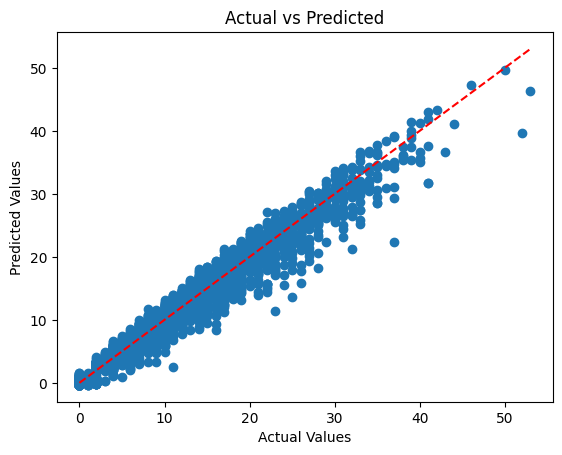

In [13]:
ls_model = LinearRegression()
ls_model.fit(X_train, y_train)

y_pred = ls_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

# Training predictions
y_train_pred = ls_model.predict(X_train)

# Training metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"\nTraining R^2: {train_r2:.4f}")
print(f"Test R^2: {r2:.4f}")

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

## Random Forest Regressor

Fitting 5 folds for each of 72 candidates, totalling 360 fits

BEST RANDOM FOREST MODEL
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Val RMSE: 1.9156

TRAINING PERFORMANCE
Training R²   : 0.9666
Training MSE  : 2.6109
Training RMSE : 1.6158

TEST PERFORMANCE
Test R²       : 0.9532
Test MSE      : 3.5914
Test RMSE     : 1.8951


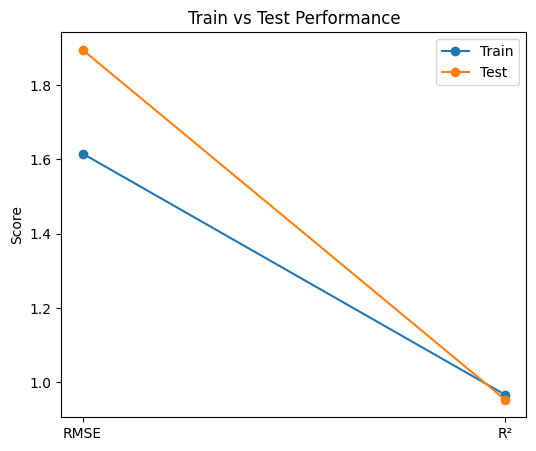

In [19]:
rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}

scoring = {
    "r2": "r2",
    "mse": "neg_mean_squared_error",
    "rmse": "neg_root_mean_squared_error"
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring=scoring,
    refit="rmse",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

print("\nBEST RANDOM FOREST MODEL")
print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Val RMSE: {-grid_search.best_score_:.4f}")

y_train_pred = best_rf.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = root_mean_squared_error(y_train, y_train_pred)

y_test_pred = best_rf.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

print("\nTRAINING PERFORMANCE")
print(f"Training R²   : {train_r2:.4f}")
print(f"Training MSE  : {train_mse:.4f}")
print(f"Training RMSE : {train_rmse:.4f}")

print("\nTEST PERFORMANCE")
print(f"Test R²       : {test_r2:.4f}")
print(f"Test MSE      : {test_mse:.4f}")
print(f"Test RMSE     : {test_rmse:.4f}")

metrics = ['RMSE', 'R²']
train_scores = [train_rmse, train_r2]
test_scores = [test_rmse, test_r2]

plt.figure(figsize=(6,5))
plt.plot(metrics, train_scores, marker='o', label='Train')
plt.plot(metrics, test_scores, marker='o', label='Test')
plt.title('Train vs Test Performance')
plt.ylabel('Score')
plt.legend()
plt.show()